# Erhan Asad Javed

## Pricing & Affordability Trends in NYC

#### What factors determine the price of an Airbnb listing in NYC?


#### Key research questions:
- How does room type impact price variations?
- What is the effect of location (neighborhood group, latitude, and longitude) on price differences?
- Does the host's listing count or years of hosting (host_since) influence listing prices?
- How do reviews per month, review scores, and the total number of reviews correlate with pricing?
- What role does availability over 365 days and minimum nights play in pricing strategies?

## EDA

### Imports

In [1]:
import os

import altair as alt
import pandas as pd
from toolz.curried import pipe
import numpy as np
import sys

# Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

sys.path.append(os.path.abspath("../../code"))
from cleaning_workflows import prepare_dataset

### Loading in the data

In [2]:
df = pd.read_csv('../../data/raw/listings.csv', parse_dates=['first_review', 'last_review'])

df.head()


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,39572,https://www.airbnb.com/rooms/39572,20250103033441,2025-01-03,city scrape,1 br in a 2 br apt (Midtown West),NaN,NaN,https://a0.muscache.com/pictures/fd1bffd9-ccf8...,169927,...,5.00,4.98,4.86,NaN,f,2,1,1,0,0.25
1,39593,https://www.airbnb.com/rooms/39593,20250103033441,2025-01-03,city scrape,A lovely room w/ a Manhattan view,"A private, furnished large room to rent Jan/F...","Nate Silver called this super safe, clean, qui...",https://a0.muscache.com/pictures/0b9110f7-3b24...,110506,...,4.96,4.79,4.93,NaN,f,1,0,1,0,0.20
2,39704,https://www.airbnb.com/rooms/39704,20250103033441,2025-01-03,previous scrape,"Private, Large & Sunny 1BR w/W&D",It's a No Brainer:<br />•Terrific Space For Le...,The Neighborhood<br />• Rich History <br />• B...,https://a0.muscache.com/pictures/0bc4e8a4-c047...,170510,...,4.92,4.38,4.72,NaN,f,2,2,0,0,1.93
3,42300,https://www.airbnb.com/rooms/42300,20250103033441,2025-01-03,city scrape,Beautiful Lower East Side Loft,Architect-owned loft is a corner unit in a bea...,"The apartment is in the border of Soho, LES an...",https://a0.muscache.com/pictures/0e285e13-ee14...,184755,...,4.87,4.57,4.62,NaN,f,1,1,0,0,0.40
4,42729,https://www.airbnb.com/rooms/42729,20250103033441,2025-01-03,city scrape,@HouseOnHenrySt - Private 2nd bedroom w/shared...,NaN,"Lovely old Brooklyn neighborhood, with brick/b...",https://a0.muscache.com/pictures/925fe213-f5e1...,11481,...,4.73,4.58,4.64,NaN,f,4,1,3,0,1.26


In [3]:
# Make a copy of the dataset
df_cleaned = df.copy()

# Drop columns with mostly missing values
df_cleaned.drop(columns=["calendar_updated", "license"], inplace=True, errors="ignore")

# Fill missing values for categorical variables
categorical_fill_values = {
    "name": "Unknown",
    "description": "No description available",
    "neighborhood_overview": "No overview available",
    "host_name": "Unknown",
    "host_location": "Not provided",
    "host_response_time": "No response time",
    "host_is_superhost": "f",
    "has_availability": "f",
    "instant_bookable": "f"
}
df_cleaned.fillna(value=categorical_fill_values, inplace=True)

# Convert date columns
date_cols = ["host_since", "last_scraped", "first_review", "last_review", "calendar_last_scraped"]
for col in date_cols:
    df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors="coerce")
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# Convert percentage columns to numeric
percentage_cols = ["host_response_rate", "host_acceptance_rate"]
for col in percentage_cols:
    df_cleaned[col] = df_cleaned[col].str.replace("%", "", regex=True).astype(float) / 100
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Convert price column to numeric
df_cleaned["price"] = df_cleaned["price"].str.replace(r"[\$,]", "", regex=True).astype(float)
df_cleaned["price"] = df_cleaned["price"].fillna(df_cleaned["price"].median())

# Fill missing numerical values with median
numerical_cols = df_cleaned.select_dtypes(include=["number"]).columns.tolist()
for col in numerical_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Fill missing values in categorical columns with the most common value
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
df_cleaned[categorical_cols] = df_cleaned[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Strip leading/trailing spaces from string columns
df_cleaned = df_cleaned.apply(lambda x: x.str.strip() if x.dtype == "object" else x)


In [4]:
df_cleaned.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,39572,https://www.airbnb.com/rooms/39572,20250103033441,2025-01-03,city scrape,1 br in a 2 br apt (Midtown West),No description available,No overview available,https://a0.muscache.com/pictures/fd1bffd9-ccf8...,169927,...,4.98,5.00,4.98,4.86,f,2,1,1,0,0.25
1,39593,https://www.airbnb.com/rooms/39593,20250103033441,2025-01-03,city scrape,A lovely room w/ a Manhattan view,"A private, furnished large room to rent Jan/F...","Nate Silver called this super safe, clean, qui...",https://a0.muscache.com/pictures/0b9110f7-3b24...,110506,...,4.96,4.96,4.79,4.93,f,1,0,1,0,0.20
2,39704,https://www.airbnb.com/rooms/39704,20250103033441,2025-01-03,previous scrape,"Private, Large & Sunny 1BR w/W&D",It's a No Brainer:<br />•Terrific Space For Le...,The Neighborhood<br />• Rich History <br />• B...,https://a0.muscache.com/pictures/0bc4e8a4-c047...,170510,...,4.89,4.92,4.38,4.72,f,2,2,0,0,1.93
3,42300,https://www.airbnb.com/rooms/42300,20250103033441,2025-01-03,city scrape,Beautiful Lower East Side Loft,Architect-owned loft is a corner unit in a bea...,"The apartment is in the border of Soho, LES an...",https://a0.muscache.com/pictures/0e285e13-ee14...,184755,...,4.85,4.87,4.57,4.62,f,1,1,0,0,0.40
4,42729,https://www.airbnb.com/rooms/42729,20250103033441,2025-01-03,city scrape,@HouseOnHenrySt - Private 2nd bedroom w/shared...,No description available,"Lovely old Brooklyn neighborhood, with brick/b...",https://a0.muscache.com/pictures/925fe213-f5e1...,11481,...,4.71,4.73,4.58,4.64,f,4,1,3,0,1.26


In [5]:
print(df_cleaned.shape)
print(df_cleaned.columns)

(37784, 73)
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_a

In [6]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37784 entries, 0 to 37783
Data columns (total 73 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            37784 non-null  int64         
 1   listing_url                                   37784 non-null  object        
 2   scrape_id                                     37784 non-null  int64         
 3   last_scraped                                  37784 non-null  datetime64[ns]
 4   source                                        37784 non-null  object        
 5   name                                          37784 non-null  object        
 6   description                                   37784 non-null  object        
 7   neighborhood_overview                         37784 non-null  object        
 8   picture_url                                   37784 non-null  obje

In [7]:
df_cleaned.isna().sum()

id                                              0
listing_url                                     0
scrape_id                                       0
last_scraped                                    0
source                                          0
                                               ..
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
reviews_per_month                               0
Length: 73, dtype: int64

In [8]:
numerical_cols = [col for col in numerical_cols if col not in ["id", "host_id"]]
print(numerical_cols)

['scrape_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']


In [9]:
object_cols = df_cleaned.select_dtypes(include=['object']).columns
print(object_cols)

Index(['listing_url', 'source', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_url', 'host_name', 'host_location', 'host_about',
       'host_response_time', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'bathrooms_text', 'amenities',
       'has_availability', 'instant_bookable'],
      dtype='object')


In [10]:
df_cleaned.describe().drop(columns=['id', 'latitude', 'longitude', 'host_id'])

,scrape_id,last_scraped,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.778400e+04,37784,37784,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,...,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000
mean,2.025010e+13,2025-01-03 00:00:00,2017-03-06 09:48:26.373067776,0.952508,0.812859,263.054864,351.429229,2.754896,1.119654,1.321723,...,4.704505,4.870094,4.867555,4.775639,4.676217,71.636354,45.435555,23.985232,0.005187,0.685365
min,2.025010e+13,2025-01-03 00:00:00,2008-08-11 00:00:00,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.025010e+13,2025-01-03 00:00:00,2014-07-07 00:00:00,1.000000,0.840000,1.000000,1.000000,2.000000,1.000000,1.000000,...,4.690000,4.890000,4.900000,4.750000,4.670000,1.000000,0.000000,0.000000,0.000000,0.160000
50%,2.025010e+13,2025-01-03 00:00:00,2016-08-02 00:00:00,1.000000,0.880000,2.000000,3.000000,2.000000,1.000000,1.000000,...,4.810000,4.950000,4.960000,4.850000,4.760000,2.000000,1.000000,1.000000,0.000000,0.290000
75%,2.025010e+13,2025-01-03 00:00:00,2019-10-29 00:00:00,1.000000,0.950000,10.000000,15.000000,4.000000,1.000000,1.000000,...,4.910000,5.000000,5.000000,4.950000,4.850000,9.000000,2.000000,2.000000,0.000000,0.550000
max,2.025010e+13,2025-01-03 00:00:00,2024-12-27 00:00:00,1.000000,1.000000,5079.000000,9048.000000,16.000000,15.500000,16.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,1154.000000,1154.000000,739.000000,4.000000,116.300000
std,1.895728e+01,NaN,NaN,0.173547,0.232501,1000.361076,1196.815995,1.903900,0.442243,0.869987,...,0.423313,0.317409,0.345344,0.331185,0.413567,224.585038,200.899492,109.136674,0.086848,1.584030


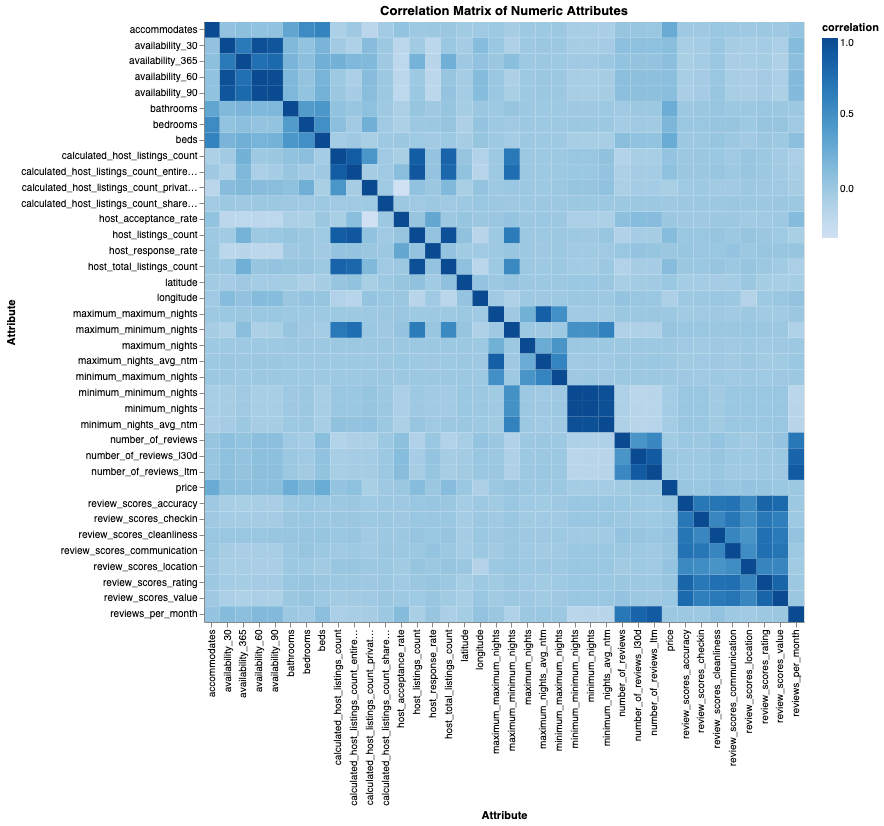

In [11]:
# Compute correlation matrix
correlation_matrix = df_cleaned[numerical_cols].corr().reset_index().melt(id_vars=["index"], var_name="variable", value_name="correlation")

# Create Altair heatmap
heatmap = alt.Chart(correlation_matrix).mark_rect().encode(
    x=alt.X("index:N", title="Attribute"),
    y=alt.Y("variable:N", title="Attribute"),
    color=alt.Color("correlation:Q", scale=alt.Scale(scheme="blues")),
    tooltip=["index", "variable", "correlation"]
).properties(
    title="Correlation Matrix of Numeric Attributes",
    width=600,
    height=600
)

# Display visualization
heatmap

#### Some basic visualizations

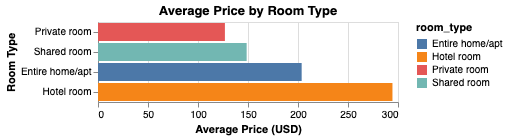

In [12]:
room_type_bar = alt.Chart(df_cleaned).mark_bar().encode(
    y=alt.Y("room_type:N", title="Room Type", sort = "x"),
    x=alt.X("mean(price):Q", title="Average Price (USD)"),
    color="room_type:N"
).properties(title="Average Price by Room Type")

room_type_bar


It seems that hotel rooms have the highest average price, followed by entire home/apt, which makes sense.

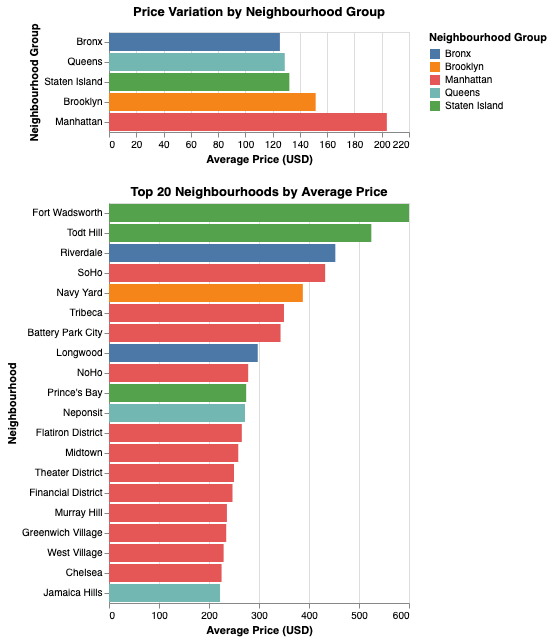

In [13]:
# Latitude, Longitude and Price
geo_bar = alt.Chart(df_cleaned).mark_bar().encode(
    y=alt.Y("neighbourhood_group_cleansed:N", title="Neighbourhood Group", sort = "x"),
    x=alt.X("mean(price):Q", title="Average Price (USD)"),
    color="neighbourhood_group_cleansed:N"
).properties(title="Price Variation by Neighbourhood Group")

top_neighbourhoods = df_cleaned.groupby(["neighbourhood_cleansed", "neighbourhood_group_cleansed"])["price"].mean().nlargest(20).reset_index()
top_neighbourhoods_chart = alt.Chart(top_neighbourhoods).mark_bar().encode(
    y=alt.Y("neighbourhood_cleansed:N", title="Neighbourhood", sort="-x"),
    x=alt.X("price:Q", title="Average Price (USD)"),
    color=alt.Color("neighbourhood_group_cleansed:N", legend=alt.Legend(title="Neighbourhood Group")),
    tooltip=["neighbourhood_cleansed", "price"]
).properties(title="Top 20 Neighbourhoods by Average Price")

geo_bar & top_neighbourhoods_chart

On average, Manhatten seems to be the most expensive neighbourhood group to rent, which makes sense due to its central location in NYC. Many of the most expensive neighbourhoods are therefore in Manhattan. 

A notable observation is that two neighbourhoods in Staten Island seem to be, on average, the most expensive neighbourhoods in New York.

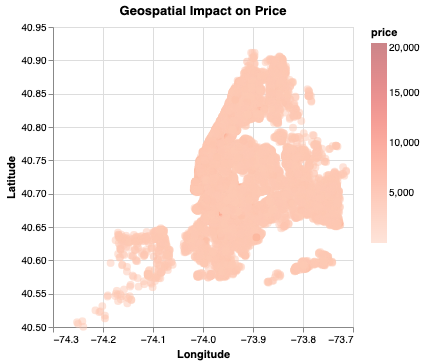

In [14]:
geo_chart = alt.Chart(df_cleaned).mark_circle(size=60, opacity=0.5).encode(
    x=alt.X("longitude:Q", title="Longitude", scale=alt.Scale(zero=False)),
    y=alt.Y("latitude:Q", title="Latitude", scale=alt.Scale(zero=False)),
    color=alt.Color("price:Q", scale=alt.Scale(scheme="reds")),
    tooltip=["latitude", "longitude", "price"]
).properties(title="Geospatial Impact on Price")

geo_chart

This map seems to resemble the layout of NYC, if compared to NYC on a map. However, the price as a colour does not seem to be helping us see any patterns. Since the most expensive neighbourhood, on average, is $600 a night, let us filter the dataset to see prices below that to understand the patterns a bit more.

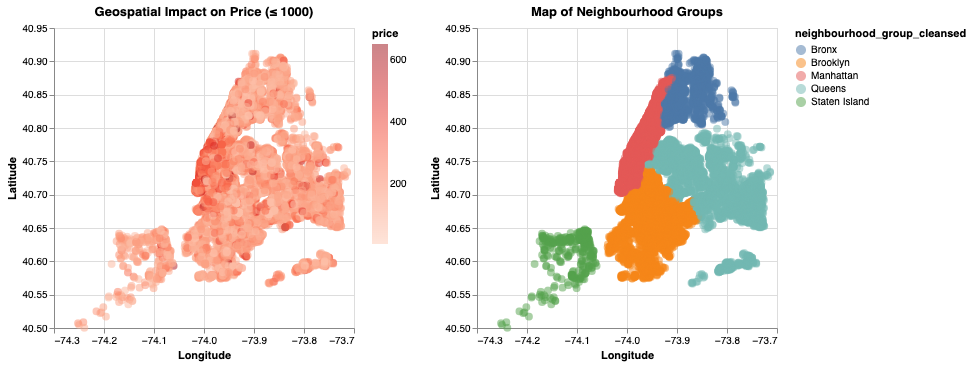

In [15]:
# Filter dataset to include prices up to 2000
df_filtered = df_cleaned[df_cleaned["price"] <= 650]

# Create geospatial chart
geo_chart2 = alt.Chart(df_filtered).mark_circle(size=60, opacity=0.5).encode(
    x=alt.X("longitude:Q", title="Longitude", scale=alt.Scale(zero=False)),
    y=alt.Y("latitude:Q", title="Latitude", scale=alt.Scale(zero=False)),
    color=alt.Color("price:Q", scale=alt.Scale(scheme="reds")),
    tooltip=["latitude", "longitude", "price"]
).properties(title="Geospatial Impact on Price (≤ 1000)")

# Create geospatial chart
geo_chart3 = alt.Chart(df_filtered).mark_circle(size=60, opacity=0.5).encode(
    x=alt.X("longitude:Q", title="Longitude", scale=alt.Scale(zero=False)),
    y=alt.Y("latitude:Q", title="Latitude", scale=alt.Scale(zero=False)),
    color=alt.Color("neighbourhood_group_cleansed:N"),
    tooltip=["latitude", "longitude", "neighbourhood_group_cleansed"]
).properties(title="Map of Neighbourhood Groups")

geo_chart2 | geo_chart3

This makes a lot more sense. If compared to New York on a map, once can see that Manhattan, on average, seems to have more expensive listings. Perhaps creating a map using this data would be helpful in identifying more complex patterns in price later on.

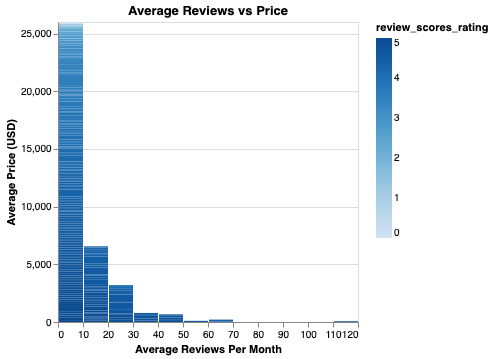

In [16]:
# Reviews correlation with pricing
reviews_bar = alt.Chart(df_cleaned).mark_bar().encode(
    x=alt.X("reviews_per_month", title="Average Reviews Per Month", bin=alt.BinParams(maxbins=20)),
    y=alt.Y("mean(price):Q", title="Average Price (USD)"),
    color="review_scores_rating:Q"
).properties(title="Average Reviews vs Price")

reviews_bar

As average reviews per month increases, the average price decreases. This could be for a number of reasons. Having less reviews in one month indicates less demand, perhaps due to higher prices and unaffordability. More complicated charts could be designed to understand why this could be a pattern.

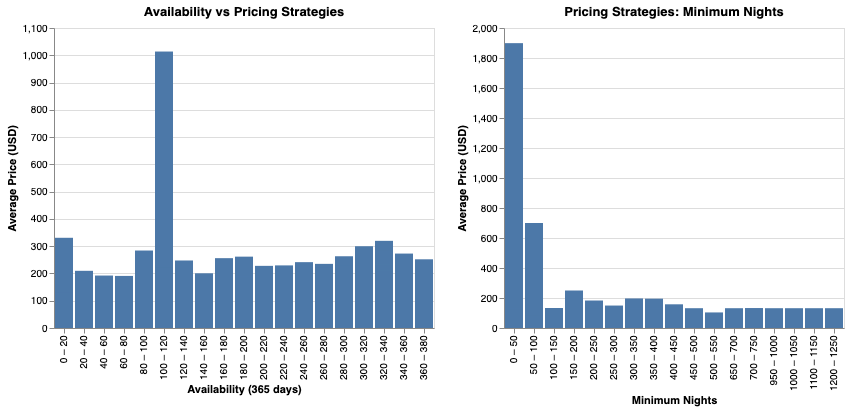

In [17]:
availability_bar = alt.Chart(df_cleaned).mark_bar().encode(
    x=alt.X("availability_365:O", title="Availability (365 days)", bin=alt.BinParams(maxbins=20)),
    y=alt.Y("mean(price):Q", title="Average Price (USD)"),
    tooltip=["availability_365", "mean(price)"]
).properties(title="Availability vs Pricing Strategies")

availability_chart = alt.Chart(df_cleaned).mark_bar().encode(
    x=alt.X("minimum_nights:O", title="Minimum Nights", bin=alt.BinParams(maxbins=30)),
    y=alt.Y("mean(price):Q", title="Average Price (USD)"),
    tooltip=["minimum_nights", "mean(price):Q"]
).properties(title="Pricing Strategies: Minimum Nights")

availability_bar | availability_chart

- For availability, we see that the price remains quite uniform regardless of the annual availability of a listing, except for 100-120 days. This may be an outlier due to data imbalance, however more evidence is required to justify this trend
- For minimum nights, we see that 0-50 minimum night listings have the highest average price and more than 50 minimum nights have lower average prices. This makes sense as short-term rentals like hotel rooms would logically be more expensive than long-term rentals who may provide discounts to long-term renters.

# Task Analysis

## Key Research Questions and Task Mapping

### **1. How does room type impact price variations?**
- **Retrieve Value**: Extract `room_type` and `price`.
- **Characterize Distribution**: Visualize the spread of prices for different room types.
- **Find Extremum**: Identify the most and least expensive room types.
- **Sort**: Rank room types by average price.
- **Visualizations:**
  - Box plot of room type vs. price.
  - Bar chart of average price per room type.

### **2. What is the effect of location (neighborhood group, latitude, and longitude) on price differences?**
- **Retrieve Value**: Extract `neighbourhood_group_cleansed`, `latitude`, `longitude`, and `price`.
- **Characterize Distribution**: Visualize price variations across different locations.
- **Determine Range**: Identify areas with the highest and lowest price variations.
- **Find Anomalies**: Detect outlier neighborhoods with extreme pricing.
- **Visualizations:**
  - Geographic heatmap of price by location.
  - Bar chart of average price per neighborhood group.
  - Scatter plot of latitude vs. longitude colored by price.

### **3. Does the host's listing count or years of hosting (host_since) influence listing prices?**
- **Retrieve Value**: Extract `host_since`, `host_listings_count`, and `price`.
- **Compute Derived Value**: Calculate host tenure (years since `host_since`).
- **Find Anomalies**: Identify whether long-time hosts charge significantly higher or lower prices.
- **Correlate**: Analyze the relationship between host tenure/listing count and pricing.
- **Visualizations:**
  - Line chart of years of hosting vs. average price.
  - Scatter plot of host listing count vs. price.
  - Bar chart of price variations by host listing count.

### **4. How do reviews per month, review scores, and the total number of reviews correlate with pricing?**
- **Retrieve Value**: Extract `reviews_per_month`, `review_scores_rating`, `number_of_reviews`, and `price`.
- **Characterize Distribution**: Examine how review frequency and ratings relate to pricing.
- **Find Extremum**: Identify listings with the highest/lowest review scores and their price trends.
- **Correlate**: Analyze the impact of reviews on pricing.
- **Visualizations:**
  - Binned bar chart of reviews per month vs. average price.
  - Scatter plot of review scores vs. price.
  - Correlation heatmap of reviews and pricing-related attributes.

### **5. What role does availability over 365 days and minimum nights play in pricing strategies?**
- **Retrieve Value**: Extract `availability_365`, `minimum_nights`, and `price`.
- **Find Extremum**: Identify listings with extreme availability values and their pricing strategies.
- **Filter**: Compare listings with low and high availability.
- **Sort**: Rank availability and minimum night requirements by price.
- **Visualizations:**
  - Scatter plot of availability_365 vs. price.
  - Bar chart of minimum nights vs. average price.
  - Grouped bar chart of pricing trends for different availability levels.